# Introduction
In this notebook, we analyse the relationships between individual Option Greeks with individual factors that influence **European (Calls) options** prices according to the Black-Scholes option pricing model.

# Black-Scholes
The Black-Scholes model is a mathematical equation that estimates the theoretical value of derivatives (mainly options), taking into account the impact of time and other risk factors:

$$C=S\times N(d_1)-K\times e^{-rT}\times N(d_2)$$

where:
- $d_1=\frac{ln^S_K+(r+\frac{\sigma^2_v}{2})t}{\sigma_s\sqrt{T}}$
- $d_2=d_1-\sigma_s\sqrt{T}$

and:
- $C$ = Call option price
- $S$ = Spot price
- $K$ = Strike price
- $r$ = Risk-free interest rate (%)
- $T$ = Time to maturity (years)
- $\sigma$ = Volatility (%)
- $N$ = A normal distribution, typically with mean 0 and standard deviation 1

Note: Our Black-Scholes implementation will have a time input in days instead of years.

In [112]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [113]:
N = norm.cdf

def d1(S, K, r, T, sigma):
    return (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))

def BS_CALL(S, K, T, r, sigma):
    d1_value = d1(S, K, r, T, sigma)
    d2 = d1_value - sigma * np.sqrt(T)
    return S * N(d1_value) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1_value = d1(S, K, r, T, sigma)
    d2 = d1_value - sigma * np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1_value)

# Constant Variables for Analysis
Throughout this analysis of Option greeks, we will assume the following default values for each factor that drives options prices:

In [114]:
S = 100         # Spot price (Change this to analyse ATM, OTM and ITM options)
K = 100         # Strike price
t = 30          # Time to maturity in DAYS
r = 0.05        # Risk-free interest rate
sigma = 0.5     # Volatility of the underlying

# Delta
Delta measures the amount of change in option price for a $1 increase in the underlying.

E.g. ABC stock is trading at $100 per share. A CALL ABC option is trading at $10 per share. If Delta = 0.5, then:
- If ABC increases to $101, CALL ABC increases to $10.5.
- If ABC decreases to $99, CALL ABC decreases to $9.5.

## Deriving Delta
Since delta measures the rate of change of the option's price w.r.t. the underlying's price, then for an European Call:
$$\Delta_{call}=N(d_1)$$
For an European Put:
$$\Delta_{put}=N(d_1)-1$$

In [115]:
def delta_call(S, K, r, T, sigma):
    d1_value = d1(S, K, r, T, sigma)
    return norm.cdf(d1_value)

## Delta vs. Spot Price

In [116]:
def delta_spot_analysis(K, r, t, sigma):
    T = t / 365
    S = np.arange(K * 0.5, K * 1.5, 1)
    calls_deltas = delta_call(S, K, r, T, sigma)

    plt.title('CALL Delta vs. Spot Price')
    plt.plot(S, calls_deltas, label='Delta')
    plt.xlabel('Spot Price')
    plt.ylabel('CALL Delta')
    plt.legend()

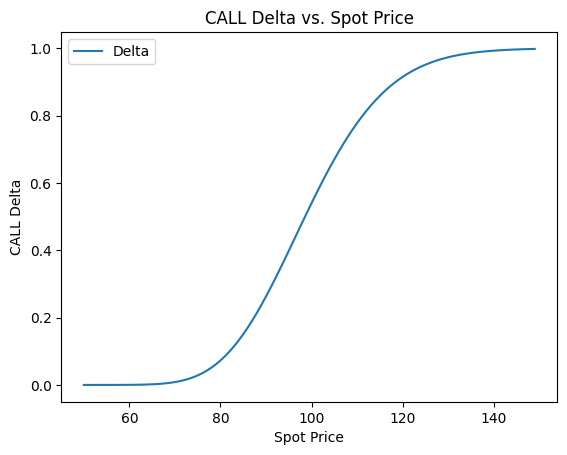

In [117]:
delta_spot_analysis(K, r, t, sigma)

## Delta vs. Time


In [118]:
def delta_time_analysis(S, K, r, sigma, moneyness):
    times = np.arange(100, 0, -1)
    calls_deltas = [delta_call(S, K, r, t/365, sigma) for t in times]

    plt.title(f'{moneyness} CALL Delta vs. Time')
    plt.plot(times, calls_deltas, label=f'{moneyness} Delta')
    plt.xlabel('Time (days)')
    plt.gca().invert_xaxis()
    plt.ylabel('CALL Delta')
    plt.legend()

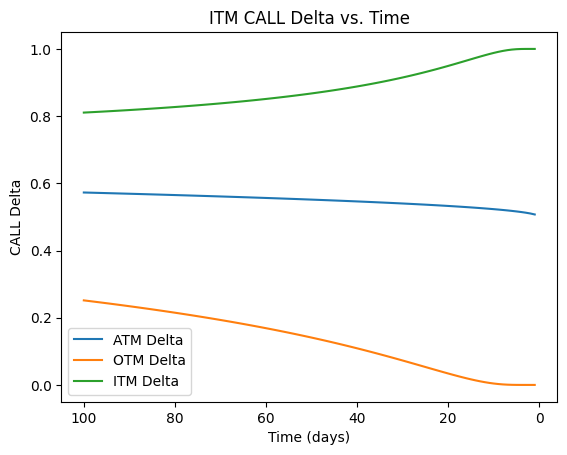

In [119]:
delta_time_analysis(S, K, r, sigma, moneyness="ATM")
delta_time_analysis(S-20, K, r, sigma, moneyness="OTM")
delta_time_analysis(S+20, K, r, sigma, moneyness="ITM")

## Delta vs Volatility

In [120]:
def delta_volatility_analysis(S, K, r, t, moneyness):
    S = np.arange(K * 0.5, K * 1.5, 1)
    volatilities = [0.05, 0.2, 0.4]
    for sig in volatilities:
        calls_deltas = delta_call(S, K, r, t/365, sig)
        plt.plot(S, calls_deltas, label=f'Delta (Volatility {int(sig * 100)}%)')

    plt.title(f'{moneyness} CALL Delta vs. Volatility')
    
    plt.xlabel('Spot price')
    plt.ylabel('CALL Delta')
    plt.legend()

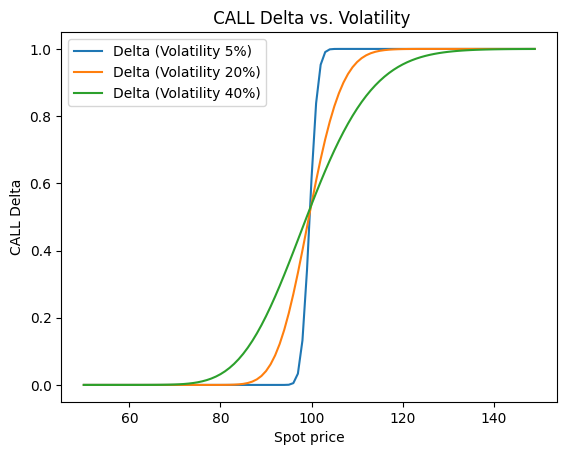

In [121]:
delta_volatility_analysis(S, K, r, t, moneyness='')

# Gamma
Gamma measures the amount of change in Delta for a $1 increase in the underlying.

E.g. ABC stock is trading at $100 per share. A CALL ABC option is trading at $10 per share. If Delta = 0.5 and Gamma = 0.15, then:
- If ABC increases to $101, CALL ABC increases to $10.5 and delta increases to 0.65.
- If ABC decreases to $99, CALL ABC decreases to $9.5 and delta decreases to 0.35.

In [122]:
def gamma_call(S, K, r, T, sigma):
    d1_value = d1(S, K, r, T, sigma)
    return norm.pdf(d1_value) / (S * sigma * np.sqrt(T))

## Gamma vs. Spot Price

In [125]:
def gamma_spot_analysis(K, r, t, sigma):
    T = t / 365
    S = np.arange(K * 0.5, K * 1.5, 1)
    calls_gammas = gamma_call(S, K, r, T, sigma)

    plt.title('CALL Gamma vs. Spot Price')
    plt.plot(S, calls_gammas, label='Gamma')
    plt.xlabel('Spot Price')
    plt.ylabel('CALL Gamma')
    plt.legend()

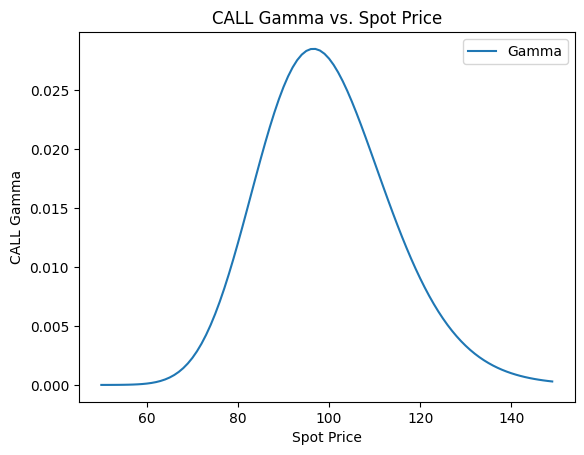

In [126]:
gamma_spot_analysis(K, r, t, sigma)

## Gamma vs. Time

In [127]:
def gamma_time_analysis(S, K, r, sigma, moneyness):
    times = np.arange(100, 0, -1)
    calls_gammas = [gamma_call(S, K, r, t/365, sigma) for t in times]

    plt.title(f'{moneyness} CALL Gamma vs. Time')
    plt.plot(times, calls_gammas, label=f'{moneyness} Gamma')
    plt.xlabel('Time (days)')
    plt.gca().invert_xaxis()
    plt.ylabel('CALL Gamma')
    plt.legend()

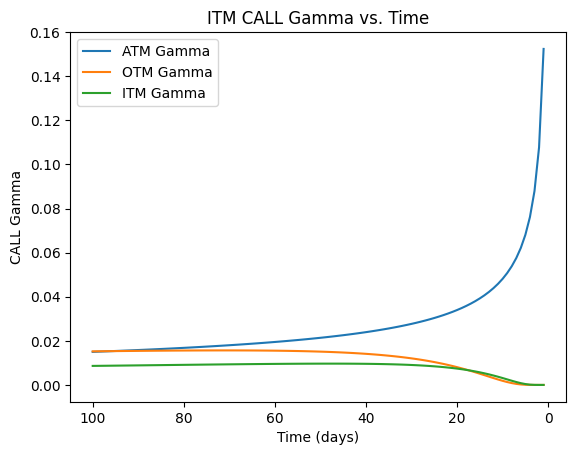

In [128]:
gamma_time_analysis(S, K, r, sigma, moneyness='ATM')
gamma_time_analysis(S-20, K, r, sigma, moneyness='OTM')
gamma_time_analysis(S+20, K, r, sigma, moneyness='ITM')

## Gamma vs. Volatility

In [129]:
def gamma_volatility_analysis(S, K, r, t, moneyness):
    S = np.arange(K * 0.5, K * 1.5, 1)
    volatilities = [0.05, 0.2, 0.4]
    for sig in volatilities:
        calls_gammas = gamma_call(S, K, r, t/365, sig)
        plt.plot(S, calls_gammas, label=f'Gamma (Volatility {int(sig * 100)}%)')

    plt.title(f'{moneyness} CALL Gamma vs. Volatility')
    
    plt.xlabel('Spot price')
    plt.ylabel('CALL Gamma')
    plt.legend()

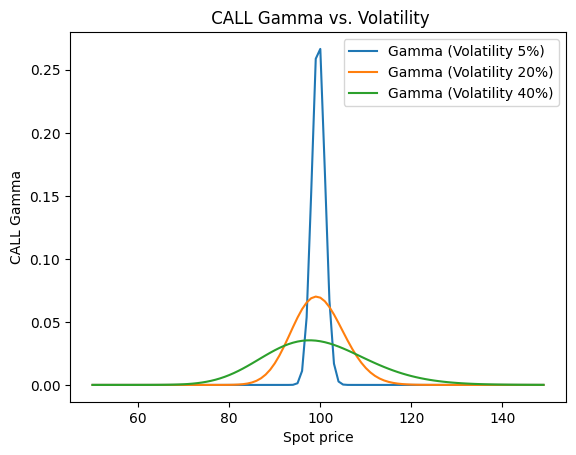

In [130]:
gamma_volatility_analysis(S, K, r, t, moneyness='')